In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import inv
from scipy.interpolate import CubicSpline
#from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib as mpl
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

from datetime import datetime
from matplotlib.dates import date2num, DayLocator, DateFormatter

In [2]:
def savefig(filename, crop = True):
    plt.savefig('{}.pdf'.format(filename))
    plt.savefig('{}.eps'.format(filename))

In [3]:
import datetime
import matplotlib.dates as mdates

today = '11/8/22' 
days = pd.date_range(start='6/13/17',end=today) 
ddd = np.arange(len(days))
t = np.reshape(ddd, [-1])

print(len(t))

# Generate some random date-time data
numdays1 = len(t)
base1 = datetime.date.fromisoformat('2017-06-13')
date_list1 = [base1 + datetime.timedelta(days=x) for x in range(0, numdays1)]

1975


In [4]:
# Data Loader Parameters
TRAIN_SPLIT = 1900

In [5]:
data = pd.read_csv('BTC-USD-daily.csv', date_parser = True)
# data.tail()

In [6]:
data = data.drop(['Date', 'Adj Close', 'Volume'], axis = 1)
data

,Open,High,Low,Close
0,465.864014,468.174011,452.421997,457.334015
1,456.859985,456.859985,413.104004,424.440002
2,424.102997,427.834991,384.532013,394.795990
3,394.673004,423.295990,389.882996,408.903992
4,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...
2970,20208.769531,21209.560547,20188.019531,21147.230469
2971,21144.832031,21446.886719,21097.634766,21282.691406
2972,21285.056641,21345.376953,20920.191406,20926.486328
2973,20924.621094,21053.246094,20489.972656,20602.816406


In [7]:
data = data.to_numpy()
data

array([[  465.864014,   468.174011,   452.421997,   457.334015],
       [  456.859985,   456.859985,   413.104004,   424.440002],
       [  424.102997,   427.834991,   384.532013,   394.79599 ],
       ...,
       [21285.056641, 21345.376953, 20920.191406, 20926.486328],
       [20924.621094, 21053.246094, 20489.972656, 20602.816406],
       [20620.449219, 20662.337891, 18754.533203, 18882.679688]])

(1975,)


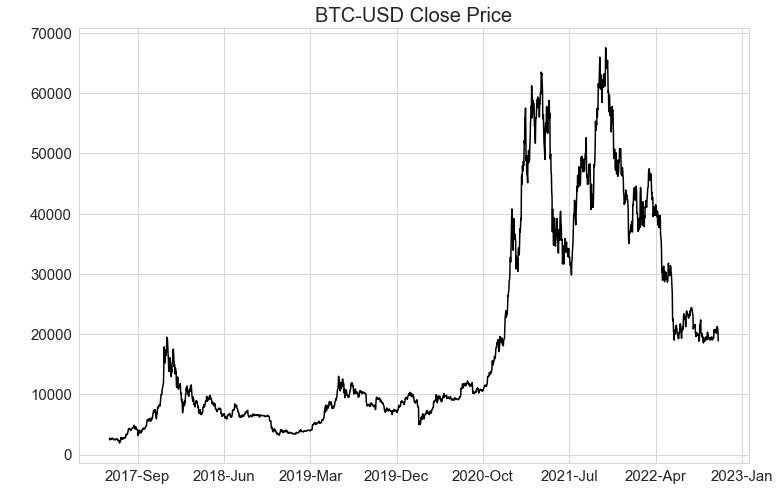

In [8]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12, 8))

Data=data[1000:,:]
uni_data = Data[:,3]
print(uni_data.shape)

ax1.plot(date_list1,uni_data,'k')
ax1.set_title('BTC-USD Close Price',fontsize = 20)
ax1.xaxis.set_major_locator(DayLocator())
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=40))
ax1.set_ylabel(' ',fontsize = 20)
ax1.tick_params(labelsize=15)

savefig('./figures/BTC-USD')

In [9]:
import datetime
import matplotlib.dates as mdates

#
Days2 = pd.date_range(start='9/10/22',end='11/8/22') 
dd2 = np.arange(len(Days2))
tt2 = np.reshape(dd2, [-1])

print(len(tt2))

numdays22 = len(tt2)
base22 = datetime.date.fromisoformat('2022-09-10')
date_list22 = [base22 + datetime.timedelta(days=x) for x in range(0, numdays22)]

#
Days3 = pd.date_range(start='10/25/22',end='11/8/22') 
dd3 = np.arange(len(Days3))
tt3 = np.reshape(dd3, [-1])

print(len(tt3))

numdays23 = len(tt3)
base23 = datetime.date.fromisoformat('2022-10-25')
date_list23 = [base23 + datetime.timedelta(days=x) for x in range(0, numdays23)]

#
Days4 = pd.date_range(start='9/10/22',end='11/8/22') 
dd4 = np.arange(len(Days4))
tt4 = np.reshape(dd4, [-1])

print(len(tt4))

numdays24 = len(tt4)
base24 = datetime.date.fromisoformat('2022-09-10')
date_list24 = [base24 + datetime.timedelta(days=x) for x in range(0, numdays24)]



60
15
60


#### GS-Method (using a portion of training data)

In [10]:
# creating AGO 
def AGO(my_data):
    k = len(my_data)

    new_data = np.zeros(k)
    ago_data = np.zeros(k)
    Z_data = np.zeros(k)

    new_data[0] = my_data[0]
    ago_data[0] = my_data[0]

    for i in range(1,k):
        new_data[i] = my_data[i]

    for i in range(1,k):
        tmp = ago_data[i-1]
        ago_data[i] = my_data[i] + tmp

    return new_data, ago_data

In [11]:
# creating Z
def Z(my_data):
    k = len(my_data)
    Z_data = np.zeros(k)

    for i in range(1,k):
        Z_data[i] = (my_data[i-1]+my_data[i])/2.0

    return Z_data

In [12]:
def OLS(X1,Z1):
    k = len(X1)
    YN = np.zeros(k-1)
    B = np.ones((k-1,2))
    
    for i in range(0,k-1):
        YN[i] = X1[i+1]
        B[i,0] = -Z1[i+1]
        
    BTB = np.dot(np.transpose(B), B)
    inv_BTB = inv(BTB)
    inv_BTB_BT = np.dot(inv_BTB,np.transpose(B))
    a_hat = np.dot(inv_BTB_BT,YN)
    
    aa = a_hat[0]
    bb = a_hat[1]
    
    return aa,bb

In [13]:
# this is equation x, the prediction

def pred_closePrice(aa,bb,Td,X0):
    X1 = np.zeros(len(X0))
    #X1[0] = X0[0]
    for i in range(0,len(X0)):
        X1[i] = (1-np.exp(aa))*((X0[0] - (bb/aa))*np.exp(-aa*(Td[i]-1)))
    return X1

In [14]:
closePrice = uni_data[1914:1960] 


In [15]:
# training data on partition 1

closePrice_train_1 = closePrice
closePrice_train_2 = uni_data

M1 = len(closePrice_train_1)
print(M1)

M2 = len(closePrice_train_2)
print(M2)

46
1975


In [16]:
# calling functions and generating values)

new_closePrice_1, AGO_closePrice_1 = AGO(closePrice_train_1)
print(AGO_closePrice_1[M1-1] - AGO_closePrice_1[M1-2])
print(closePrice_train_1[M1-1])

Z_closePrice_1 = Z(AGO_closePrice_1)

print(Z_closePrice_1[1:10])
print(AGO_closePrice_1[1:10])

aa_1,bb_1 = OLS(new_closePrice_1,Z_closePrice_1)

Td_1 = np.linspace(1,M1,M1)

closePrice_pred_1 = pred_closePrice(aa_1,bb_1,Td_1,closePrice_train_1)

19345.572265999974
19345.572266
[ 32221.4218755  53946.3193365  76016.1718755  97349.7500005
 117618.648438  137589.798829  157326.69629   177276.776368
 197050.3173835]
[ 43061.691407  64830.947266  87201.396485 107498.103516 127739.19336
 147440.404298 167212.988282 187340.564454 206760.070313]


In [17]:
print(closePrice_train_1[M1-1])

19345.572266


In [18]:
print(closePrice_pred_1[M1-1])

18956.42326790134


In [19]:
# computing SSE, MAE, MSE, MAPE, MRE

sum1 = 0
for i in range(0,M1):
    sum1 = sum1 + (closePrice_train_1[i] - closePrice_pred_1[i])**2
SSE = sum1

sum2 = 0
for i in range(0,M1):
    sum2 = sum2 + np.abs(closePrice_train_1[i] - closePrice_pred_1[i])
MAE = sum2/M1

sum3 = 0
for i in range(0,M1):
    sum3 = sum3 + (closePrice_train_1[i] - closePrice_pred_1[i])**2
MSE = sum3/M1

RMSE = np.sqrt(MSE)

sum4 = 0
for i in range(0,M1):
    sum4 = sum4 + np.abs((closePrice_train_1[i] - closePrice_pred_1[i])/closePrice_train_1[i])
MRE = (sum4/M1)

MAPE = MRE*100

print(SSE)
print(MAE)
print(MSE)
print(RMSE)
print(MRE)
print(MAPE)

20120889.890613172
464.77769920104043
437410.6497959385
661.3702819116826
0.02322070487019636
2.3220704870196363


In [20]:
### updating the prediction from the GS-method

## ODE solver to verify least squares is working correctly
from scipy.integrate import odeint,solve_ivp

def GS_ODE(par,init_cond, t0,tf,incr):
    t=np.linspace(t0,tf,incr)
    def f(y,t):
        f0 = -par[0]*y + par[0]
        df=f0
        return df
    soln = odeint(f,init_cond,t)
    return (soln,t)


t0 = 1914
tf = 1913+M1+14
incr = 200
init_cond = closePrice_pred_1[0]

par = [aa_1,bb_1]
F0,T = GS_ODE(par,init_cond,t0,tf,incr)

print(len(F0))


200


In [21]:
nd = M1+14
cs = CubicSpline(T,F0) #smooth data technique, helps to interpolate and remove/generate data

cs_Tdd = np.linspace(1914,1913+M1+14,nd)
cs_F0 = cs(cs_Tdd)

TT = cs_Tdd.flatten()
F00 = cs_F0.flatten()

print(len(F00))

60


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


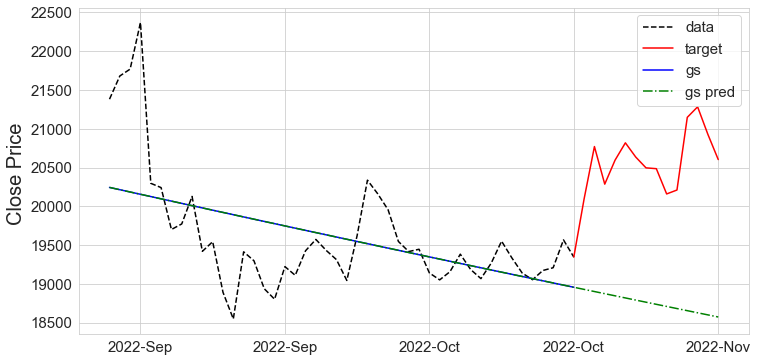

In [22]:
# plottng GS, used too much data which is why doesnt look great. but this makes our point and introduce AGS
# history is not great for GS, unlike lstm, but when a and b is nonlinear we can use history

fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12, 6))
ax1.xaxis.set_major_locator(DayLocator())
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax1.set_ylabel('Close Price ',fontsize = 20)
ax1.tick_params(labelsize=15)
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
ax1.plot(date_list24[0:46],closePrice_train_1,'k--') # data
ax1.plot(date_list24[45:],uni_data[1959:-1],'r-') # target
ax1.plot(date_list24[0:46],closePrice_pred_1,'b') # gs train
ax1.plot(date_list24[0:],F00,'g-.') # gs pred

plt.legend(('data','target','gs', 'gs pred'),loc='best',fontsize = 15)
    
savefig('./figures/gs')


In [23]:
# include this parameter values in the thesis

print(aa_1) # this is the value of parameter a, small
print(bb_1) # this is the value of parameter b, large, consistent with nature paper

0.0014599340171982888
20260.06516233855


In [24]:
print(F00[0:10])
print(closePrice_pred_1[0:10])

[20243.6236725  20214.09258326 20184.60427454 20155.1590148
 20125.75670333 20096.39726672 20067.08086725 20037.8069013
 20008.57574892 19979.38731934]
[20243.6236725  20214.09088088 20184.60117373 20155.15448819
 20125.75076151 20096.389931   20067.07193409 20037.7967083
 20008.56419122 19979.37432055]


#### adaptive-GS

In [25]:
import tensorflow.compat.v1 as tf
import timeit
import time
from tqdm import tqdm

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [26]:
#
closePrice_train_2_mean = closePrice_train_2[:TRAIN_SPLIT].mean()
closePrice_train_2_std = closePrice_train_2[:TRAIN_SPLIT].std()

closePrice_train_2 = (closePrice_train_2-closePrice_train_2_mean)/closePrice_train_2_std

new_closePrice_2, AGO_closePrice_2 = AGO(closePrice_train_2[1914:1960])
Z_closePrice_2 = Z(AGO_closePrice_2)

print(len(closePrice_train_2))
print(len(new_closePrice_2))
print(len(AGO_closePrice_2))
print(len(Z_closePrice_2))

# plt.plot(closePrice_train_1,'r')
# plt.plot(new_closePrice_1,'b--')

# plt.plot(AGO_closePrice_1,'r')
# plt.plot(Z_closePrice_1,'b--')

1975
46
46
46


In [27]:
# feed forward network whose loss function comprises of data loss and residual loss (pinn) 
#

class PINN_ags:
    # Initialize the class
    def __init__(self, t, x, Z, AGO, layers1, layers2, layers3, lb, ub):
        
        self.lb = lb
        self.ub = ub
        
        self.t = t
        self.x = x 
        self.Z = Z
        self.AGO = AGO
        
        self.layers1 = layers1
        self.layers2 = layers2
        self.layers3 = layers3
        
        self.weights1, self.biases1 = self.initialize_NN(layers1)
        self.weights2, self.biases2 = self.initialize_NN(layers2)
        self.weights3, self.biases3 = self.initialize_NN(layers3)
        
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
#         self.aa = tf.Variable([0.1], dtype=tf.float32)
#         self.bb = tf.Variable([0.1], dtype=tf.float32)
        
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.Z_tf = tf.placeholder(tf.float32, shape=[None, self.Z.shape[1]])
        self.AGO_tf = tf.placeholder(tf.float32, shape=[None, self.AGO.shape[1]])

        self.x_pred, self.Z_pred, self.AGO_pred = self.net_GS(self.t_tf)
        self.a_pred = self.a_net(self.t_tf)
        self.b_pred = self.b_net(self.t_tf)
        
        self.l1,self.l2 = self.net_l(self.t_tf)

# data loss defined here and residual loss incorporated
        self.loss = tf.reduce_mean(tf.square(self.x_tf - self.x_pred)) + \
                    tf.reduce_mean(tf.square(self.Z_tf - self.Z_pred)) + \
                    tf.reduce_mean(tf.square(self.AGO_tf - self.AGO_pred)) + \
                    tf.reduce_mean(tf.square(self.l1)) + \
                    tf.reduce_mean(tf.square(self.l2))
        
#                     tf.reduce_mean(tf.square(0.0014599340171982892 - self.a_pred[0])) + \
#                     tf.reduce_mean(tf.square(20260.06516233855 - self.b_pred[0])) + \

        

        self.optimizer = tf.train.AdamOptimizer(1e-3)
        self.train_op = self.optimizer.minimize(self.loss)
        self.loss_log = []
        init = tf.global_variables_initializer()
        self.sess.run(init)

# initalize network, generate values and start updating
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases

# initialization method when constructing from scratch
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

# first ffn, for x0,x1,z1 predict
    def neural_net(self, t, layers1, weights1, biases1):
        num_layers = len(layers1)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights1[l]
            b = biases1[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights1[-1]
        b = biases1[-1]
        #Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        Y = tf.add(tf.matmul(H, W), b)
        return Y

# second ffn, for the a param
    def neural_net2(self, t, layers2, weights2, biases2):
        num_layers = len(layers2)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights2[l]
            b = biases2[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights2[-1]
        b = biases2[-1]
        #Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        Y = tf.add(tf.matmul(H, W), b)
        return Y

# third ffn, for the b param
    def neural_net3(self, t, layers3, weights3, biases3):
        num_layers = len(layers3)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights3[l]
            b = biases3[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights3[-1]
        b = biases3[-1]
        #Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
# output of ffn1    
    def net_GS(self, t):
        GS = self.neural_net(t, self.layers1, self.weights1, self.biases1)
        x = GS[:,0:1]
        Z = GS[:,1:2]
        AGO = GS[:,2:3]

        return x, Z, AGO

# output of ff2
    def a_net(self,t):
        a = self.neural_net2(t, self.layers2, self.weights2, self.biases2)

        return a

# output of ff3
    def b_net(self,t):
        b = self.neural_net3(t, self.layers3, self.weights3, self.biases3)

        return b

# residual loss function, gm11 constraint
    def net_l(self, t):
        aa = self.a_net(t)
        bb = self.b_net(t)
        
        x,Z,AGO = self.net_GS(t)
        AGO_t = tf.gradients(AGO, t)[0]
        
        l1 = AGO_t + aa*AGO - bb
        l2 = x + aa*Z - bb
        
        return l1,l2
        
# training the model, record loss to see how loss is behaving per epoch for hyperparameter tuning        
    def train(self, nIter):
        tf_dict = {self.t_tf: self.t, self.x_tf: self.x, self.Z_tf: self.Z, self.AGO_tf: self.AGO}
        start_time = timeit.default_timer()

        for it in tqdm(range(nIter)):
            self.sess.run(self.train_op, tf_dict)
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                self.loss_log.append(loss_value)
#                 bb_value = self.sess.run(self.bb)
#                 aa_value = self.sess.run(self.aa)
                start_time = timeit.default_timer()
        
# all the predicted values seen        
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        x_star = self.sess.run(self.x_pred, tf_dict)
        Z_star = self.sess.run(self.Z_pred, tf_dict)
        AGO_star = self.sess.run(self.AGO_pred, tf_dict)
        a_star = self.sess.run(self.a_pred, tf_dict)
        b_star = self.sess.run(self.b_pred, tf_dict)
        
        return x_star, Z_star, AGO_star, a_star, b_star

In [28]:
# training the network

niter = 40000  # number of Epochs
layers1 = [1, 60, 60, 60, 3] #way the first NETWORK not layer is constructed, 60 units, 3 outputs
layers2 = [1, 60, 60, 1] #second network, a as output
layers3 = [1, 60, 60, 1] #third network, b as output

In [29]:
Td = np.linspace(1914,1913+M1,M1)
print(len(Td))

46


In [30]:
#generating more data points just for training, 60 stretched to 1000
#data transformed back to 60 days after training
t_t = Td.flatten()
nd = 1000
cs0 = CubicSpline(t_t,new_closePrice_2)
cs1 = CubicSpline(t_t,Z_closePrice_2)
cs2 = CubicSpline(t_t,AGO_closePrice_2)

Td = np.linspace(1914,1913+M1,nd)
cs_x = cs0(Td)
cs_Z = cs1(Td)
cs_AGO = cs2(Td)

t_train = Td.flatten()[:,None]
x_train = cs_x.flatten()[:,None]
Z_train = cs_Z.flatten()[:,None]
AGO_train = cs_AGO.flatten()[:,None]

In [31]:
# x_train_mean = x_train.mean()
# x_train_std = x_train.std()

# Z_train_mean = Z_train.mean()
# Z_train_std = Z_train.std()

# AGO_train_mean = AGO_train.mean()
# AGO_train_std = AGO_train.std()

In [32]:
# x_train = (x_train-x_train_mean)/x_train_std
# Z_train = (Z_train-Z_train_mean)/Z_train_std
# AGO_train = (AGO_train-AGO_train_mean)/AGO_train_std

In [33]:
# Doman bounds
lb = t_train.min(0)
ub = t_train.max(0)
# call function and train model, tqdm shows the training below
model = PINN_ags(t_train, x_train, Z_train, AGO_train, layers1, layers2, layers3, lb, ub)
model.train(niter)

Device mapping: no known devices.


100%|██████████| 40000/40000 [02:05<00:00, 319.19it/s]


In [34]:
# prediction
x_pred, Z_pred, AGO_pred, a_pred, b_pred = model.predict(t_train)
# x_pred, Z_pred, AGO_pred = model.predict(t_train)

In [35]:
# flatten array
x_pred = x_pred.flatten()
Z_pred = Z_pred.flatten()
t_train = t_train.flatten()

a_pred = a_pred.flatten()
b_pred = b_pred.flatten()

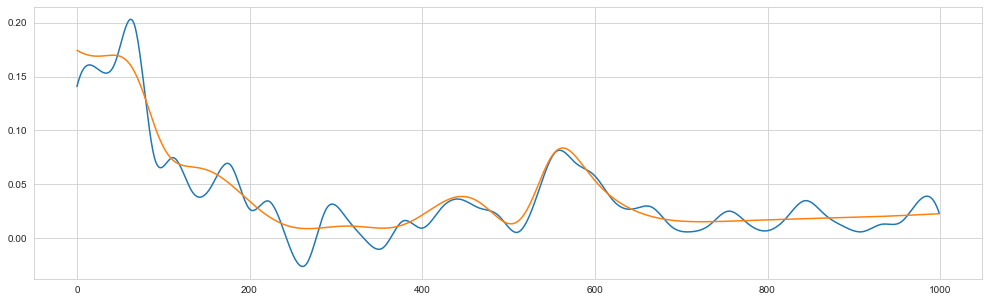

In [36]:
#plt.plot(Z_train)
# plot of the stretched 1000 points
plt.plot(x_train)
plt.plot(x_pred)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


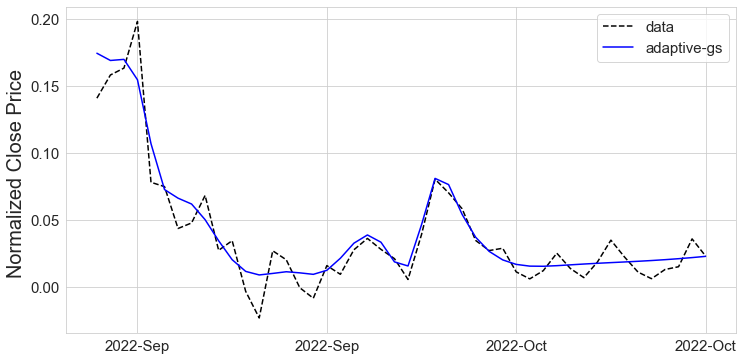

In [37]:
nd = 1000
newTd = np.linspace(1914,1913+M1,nd)
newt_t = newTd.flatten()
new_cs0 = CubicSpline(newt_t,x_pred)
new_cs3 = CubicSpline(newt_t,a_pred)
new_cs4 = CubicSpline(newt_t,b_pred)

newTd = np.linspace(1914,1913+M1,M1)
new_cs_x = new_cs0(newTd)
new_cs_a = new_cs3(newTd)
new_cs_b = new_cs4(newTd)

newx_pred = new_cs_x.flatten()[:,None]
newa_pred = new_cs_a.flatten()[:,None]
newb_pred = new_cs_b.flatten()[:,None]

fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12, 6))
ax1.xaxis.set_major_locator(DayLocator())
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax1.set_ylabel('Normalized Close Price ',fontsize = 20)
ax1.tick_params(labelsize=15)
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
ax1.plot(date_list24[0:46],closePrice_train_2[1914:1960],'k--') # data
#ax1.plot(date_list24[45:],closePrice_train_2[1959:-1],'r-') # target
ax1.plot(date_list24[0:46],newx_pred,'b') # adaptivegs train
#ax1.plot(date_list24[0:],F00,'g-.') # adaptive-gs pred

plt.legend(('data','adaptive-gs', 'adaptive-gs pred'),loc='best',fontsize = 15)
#plt.legend(('data','target','adaptive-gs', 'adaptive-gs pred'),loc='best',fontsize = 15)
    
savefig('./figures/adaptive-gs')


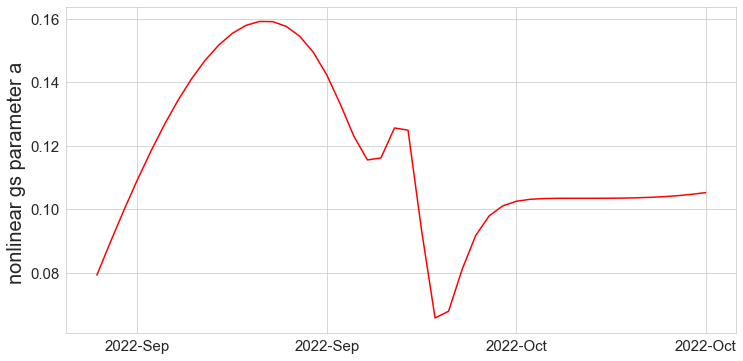

In [38]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12, 6))
ax1.xaxis.set_major_locator(DayLocator())
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax1.set_ylabel('nonlinear gs parameter a ',fontsize = 20)
ax1.tick_params(labelsize=15)
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
ax1.plot(date_list24[0:46],newa_pred,'r') # adaptive-gs-b

savefig('./figures/adaptive-gs-a')

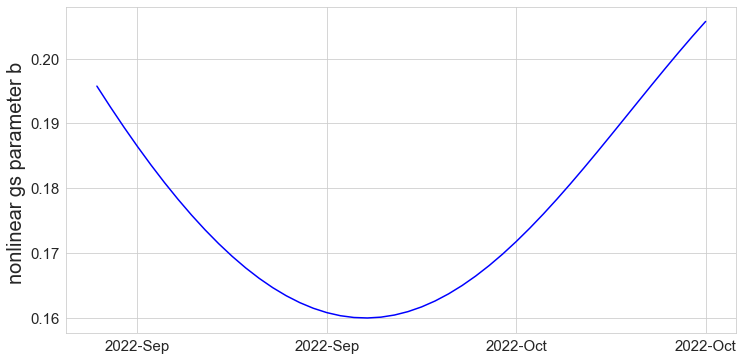

In [39]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12, 6))
ax1.xaxis.set_major_locator(DayLocator())
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax1.set_ylabel('nonlinear gs parameter b ',fontsize = 20)
ax1.tick_params(labelsize=15)
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
ax1.plot(date_list24[0:46],newb_pred,'b') # adaptive-gs-b

savefig('./figures/adaptive-gs-b')

In [40]:
#tried to extend the results, NOT COMPLETE
#will do this in future work

a_mean = newa_pred.mean()
b_mean = newb_pred.mean()

print(a_mean)
print(b_mean)

0.11574029010248636
0.17581722644314338


In [41]:
print(newTd)

[1914. 1915. 1916. 1917. 1918. 1919. 1920. 1921. 1922. 1923. 1924. 1925.
 1926. 1927. 1928. 1929. 1930. 1931. 1932. 1933. 1934. 1935. 1936. 1937.
 1938. 1939. 1940. 1941. 1942. 1943. 1944. 1945. 1946. 1947. 1948. 1949.
 1950. 1951. 1952. 1953. 1954. 1955. 1956. 1957. 1958. 1959.]


In [42]:
NewTd = np.linspace(1914,197,60)
NN = len(NewTd)
print(NewTd)

[1914.         1884.89830508 1855.79661017 1826.69491525 1797.59322034
 1768.49152542 1739.38983051 1710.28813559 1681.18644068 1652.08474576
 1622.98305085 1593.88135593 1564.77966102 1535.6779661  1506.57627119
 1477.47457627 1448.37288136 1419.27118644 1390.16949153 1361.06779661
 1331.96610169 1302.86440678 1273.76271186 1244.66101695 1215.55932203
 1186.45762712 1157.3559322  1128.25423729 1099.15254237 1070.05084746
 1040.94915254 1011.84745763  982.74576271  953.6440678   924.54237288
  895.44067797  866.33898305  837.23728814  808.13559322  779.03389831
  749.93220339  720.83050847  691.72881356  662.62711864  633.52542373
  604.42372881  575.3220339   546.22033898  517.11864407  488.01694915
  458.91525424  429.81355932  400.71186441  371.61016949  342.50847458
  313.40677966  284.30508475  255.20338983  226.10169492  197.        ]


In [43]:
pred_ags = np.zeros(NN)
for i in range(0,NN):
    pred_ags[i] = (1-np.exp(newa_pred[-1]))*((newx_pred[0]-\
                                       (newa_pred[-1]/newa_pred[-1]))*np.exp(-newa_pred[-1]*(NewTd[i]-1)))
    

In [44]:
# nd = 1000
# newTd = np.linspace(1914,1913+M1,nd)
# newt_t = newTd.flatten()
# new_cs0 = CubicSpline(newt_t,x_pred)
# new_cs3 = CubicSpline(newt_t,a_pred)
# new_cs4 = CubicSpline(newt_t,b_pred)

# newTd = np.linspace(1914,1913+M1,M1)
# new_cs_x = new_cs0(newTd)
# new_cs_a = new_cs3(newTd)
# new_cs_b = new_cs4(newTd)

# newx_pred = new_cs_x.flatten()[:,None]
# newa_pred = new_cs_a.flatten()[:,None]
# newb_pred = new_cs_b.flatten()[:,None]

# fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12, 6))
# ax1.xaxis.set_major_locator(DayLocator())
# ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
# ax1.set_ylabel('Normalized Close Price ',fontsize = 20)
# ax1.tick_params(labelsize=15)
# ax1.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
# ax1.plot(date_list24[0:46],closePrice_train_2[1914:1960],'k--') # data
# ax1.plot(date_list24[45:],closePrice_train_2[1959:-1],'r-') # target
# ax1.plot(date_list24[0:46],newx_pred,'b') # adaptivegs train
# ax1.plot(date_list24[45:],pred_ags,'g-.') # adaptive-gs pred

# plt.legend(('data','target','adaptive-gs', 'adaptive-gs pred'),loc='best',fontsize = 15)
    
# savefig('./figures/adaptive-gs2')
